# Notebook Instructions
<i>You can run the notebook document sequentially (one cell at a time) by pressing <b> shift + enter</b>. While a cell is running, a [*] will display on the left. When it has been run, a number will display indicating the order in which it was run in the notebook [8].</i>

<i>Enter edit mode by pressing <b>`Enter`</b> or using the mouse to click on a cell's editor area. Edit mode is indicated by a green cell border and a prompt showing in the editor area.</i> <BR>
    
This course is based on specific versions of python packages. You can find the details of the same in <a href='https://quantra.quantinsti.com/quantra-notebook' target="_blank" >this manual</a>. The manual also explains how to use these codes in other versions of python packages. <BR>

# The Triple Barrier Method

## How to label a dataset correctly
A standard approach in financial machine learning is to try to predict how the price will change after N bars pass. For example, to predict how the price will change after the next 30 minutes and go long or short according to the forecast. However, when real traders open a position after a signal, they (should!) already have in mind their profit goals and stop losses. That is, although they care what happens at the end of the 30 minutes, they care more about what happens during that period. The path the prices take matters!

## Triple barrier labelling
We want to know what will happen during the next N bars. Will, we hit our stop-loss? Will we reach our profit-taking level? Or with the price move in a narrow range and so it is better not to enter at all? We can address this with what we call the triple barrier method, with three barriers: horizontal ones for stop loss and profit-taking, and one vertical for reaching the end of the period without touching the other two. There is no need for the horizontal barriers to be symmetric and static let's kept it fixed and symmetric for illustration.

You will learn to figure out which of the three barriers will be touched first. The position that we take after N bars is solely determined by which barrier is touched first.

In [1]:
# Import the modules
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

## Import the Data

In [2]:
# Stock data is stored in the directory 'data'
path = '../data/'
# Read the pickle file
data = pd.read_csv(path+'/msft_ohlcv_Jan_2019_to_Dec_2019.csv')
# Print the top 5 rows of the dataframe
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-12-31,34.000000,34.220001,32.919998,33.450001,32.100094,8455500
1,2019-01-02,32.849998,33.810001,32.410000,33.639999,32.282429,7662300
2,2019-01-03,33.340000,33.680000,32.200001,32.250000,30.948524,11618300
3,2019-01-04,32.799999,33.570000,32.430000,33.330002,31.984938,10784000
4,2019-01-07,33.709999,34.970001,33.480000,34.360001,32.973373,10722300


## Feature and Label Window
Feature window is the N bars after which we want to figure out the position we should take. The price bars in this window are passed as the predictor variable to the machine learning algorithm. The label window is M bars after the Feature window. It is used for generating labels corresponding to the features from the feature window. The length of these both are generally set based on empirical observation or computational ability.

We also use a prefixed daily return threshold to use as the horizontal barriers for taking profit (upper) and stopping loss (lower).

In [3]:
# The time window for the features - N
feature_window = 60

# The time window for the labels - M
label_window = 10

# Fixed return threshold for setting horizontal barriers in the label window
threshold = 0.03

# Slicing out the data using the respective window lengths
feature_window_data = data['Adj Close'][:feature_window+1]
label_window_data = data['Adj Close'][feature_window:feature_window+label_window+1]

## The labelling method
In this code, we show the logic of how we will use the M sized label window to come up with a label encoding. First, we find the cumulative percentage change in the adjusted close price from the beginning of the label window. Thereafter we define a function called triple_barrier_target_class. In this method, we iterate over all cumulative percentage changes between the price of the first day of the label window and each day. If at any day, the cumulative return of that day surpasses a positive fixed threshold it implies that the upper horizontal barrier was hit. Hence, we return 1 and take a buy position. If, the cumulative return of that day is lower than a negative fixed threshold it implies that the lower horizontal barrier was hit. Hence, we return -1 and take a buy position. If at the end of the iteration, neither was hit we return 0 implying that the vertical barrier was hit and we took no position.

In [4]:
# Calculate the percentage change beginning to each day of the label window
label_window_cum_returns = (label_window_data.pct_change()+1).cumprod()


def triple_barrier_target_class(label_window_cum_returns, threshold):
    # For each percentage change from the beginning
    for cum_returns in label_window_cum_returns:
        # Check if the percentage change is greater than the threshold for any day
        if cum_returns > 1+threshold:
            # This implies that it touched the upper horizontal barrier and we take buy position
            return 1
        # Check if the percentage change is less than the threshold for any day
        if cum_returns < 1-threshold:
            # This implies that it touched the lower horizontal barrier and we take sell position
            return -1
    # If on no day it is lower than or higher than the preset threshold
    # it implies that it touched the vertical barrier and we take no position
    return 0

## The Label
Here from the example, we got a window where the upper horizontal barrier was breached first. Hence the label was set to 1 indicating that the upper barrier is hit first and we should take profit and hence our position should be buy.

In [5]:
label = triple_barrier_target_class(label_window_cum_returns, threshold)
print("The Target Class is ", label)

The Target Class is  1


## Plotting
Let's visualise labelling via the triple barrier method. The time series in blue are the feature bars or window we talked about earlier. The time series in orange is the one corresponding to the label window or bars. The dotted lines are the upper (red) and lower (green) horizontal barriers. As you can see, the upper horizontal barrier is breached first by the orange time series. This is before it touches either the lower horizontal barrier or the vertical barrier (dotted blue line) at the right edge of the graph. This is consistent with the label we got previously.

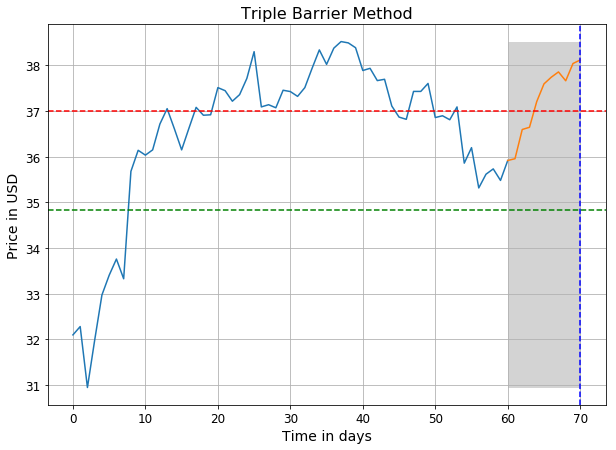

In [6]:
# Define the figure size for the plot
plt.figure(figsize=(10, 7))

# Define the label for the title of the figure
plt.title("Triple Barrier Method", fontsize=16)

# Define the labels for x-axis and y-axis
plt.xlabel("Time in days", fontsize=14)
plt.ylabel("Price in USD", fontsize=14)

# Define the tick size for x-axis and y-axis
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()

# Plotting both the feature window bars and label window bars
feature_window_data.plot()
label_window_data.plot()

# Plot horizontal barriers as a function of the last traded price of the feature window
plt.axhline(y=feature_window_data.iloc[-1]
            * (1+threshold), color='r', linestyle="--")
plt.axhline(y=feature_window_data.iloc[-1]
            * (1-threshold), color='g', linestyle="--")

# Plot vertical barrier or horizon at the end of the label window
plt.axvline(x=feature_window+label_window, color='b', linestyle="--")

# Feature and label window put together
feature_label_window_data = data['Adj Close'][0:feature_window+label_window+1]

# Greying the label window
plt.fill_between(label_window_data.index, feature_label_window_data.min(
), feature_label_window_data.max(), facecolor='lightgrey')

plt.grid()
plt.show()

## Conclusion
Here, with a very simple example involving just one feature and one label window and fixed barrier thresholds we learnt how the triple barrier method works. One nice exercise to reinforce what we learnt in this notebook will be to have dynamic horizontal barriers instead of a fixed one. Dynamic barriers will be a function of the short term volatility.